In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random



import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

# Computing the spectral decomposition using the FFT

In [2]:
domain = jnp.array([0,1])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
f = lambda x: jnp.cos(2*jnp.pi*x) + 2*jnp.sin(2*jnp.pi*4*x)

In [4]:
n_points = 100
grid = jnp.linspace(domain[0], domain[1], n_points)

In [5]:
y_values = f(grid)

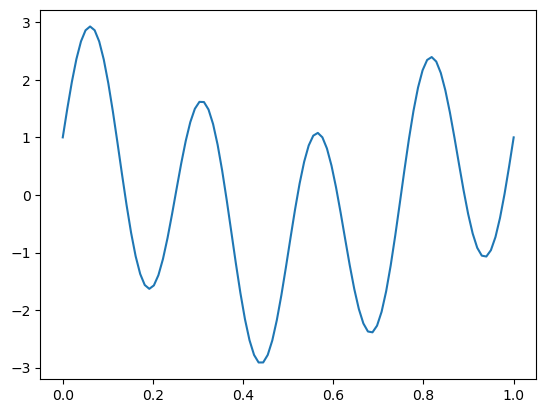

In [6]:
plt.plot(grid, y_values)

In [7]:
from jax.numpy import fft

In [8]:
alpha = fft.fft(y_values)

In [9]:
alpha.shape

(100,)

In [10]:
alpha

Array([ 1.        +0.00000000e+00j, 50.23467546+1.05387703e+00j,
       -0.25956919-1.32402682e+00j,  0.18314295-3.29410720e+00j,
       12.36881556-9.84512701e+01j, -0.76952774+4.58774434e+00j,
       -0.49050447+2.41658375e+00j, -0.3992566 +1.68948687e+00j,
       -0.35450836+1.31627630e+00j, -0.32834612+1.08507545e+00j,
       -0.3114331 +9.25702238e-01j, -0.29975411+8.08015012e-01j,
       -0.29130099+7.16839951e-01j, -0.28496176+6.43664349e-01j,
       -0.2800736 +5.83320445e-01j, -0.27621862+5.32476809e-01j,
       -0.2731214 +4.88881831e-01j, -0.27059379+4.50954517e-01j,
       -0.26850336+4.17549292e-01j, -0.26675452+3.87813927e-01j,
       -0.26527677+3.61100059e-01j, -0.26401712+3.36904823e-01j,
       -0.26293508+3.14831597e-01j, -0.26199927+2.94562910e-01j,
       -0.26118505+2.75841287e-01j, -0.26047284+2.58455458e-01j,
       -0.25984694+2.42230210e-01j, -0.25929462+2.27018836e-01j,
       -0.25880547+2.12697402e-01j, -0.25837093+1.99160351e-01j,
       -0.25798389+1.8631

In [11]:
def get_cos_sin_coef(alpha):
    n = alpha.shape[0]
    c = alpha[0].real/n
    a = 2*alpha.real/n
    b = -2*alpha.imag/n
    return a, b, c

In [12]:
a,b, c = get_cos_sin_coef(alpha)

In [13]:
c

Array(0.01, dtype=float64)

In [14]:
a[0]/2

Array(0.01, dtype=float64)

In [15]:
b

Array([-0.00000000e+00, -2.10775405e-02,  2.64805364e-02,  6.58821440e-02,
        1.96902540e+00, -9.17548869e-02, -4.83316751e-02, -3.37897375e-02,
       -2.63255260e-02, -2.17015089e-02, -1.85140448e-02, -1.61603002e-02,
       -1.43367990e-02, -1.28732870e-02, -1.16664089e-02, -1.06495362e-02,
       -9.77763662e-03, -9.01909034e-03, -8.35098585e-03, -7.75627854e-03,
       -7.22200118e-03, -6.73809645e-03, -6.29663195e-03, -5.89125819e-03,
       -5.51682575e-03, -5.16910915e-03, -4.84460420e-03, -4.54037673e-03,
       -4.25394803e-03, -3.98320702e-03, -3.72634193e-03, -3.48178667e-03,
       -3.24817836e-03, -3.02432313e-03, -2.80916869e-03, -2.60178174e-03,
       -2.40132963e-03, -2.20706496e-03, -2.01831290e-03, -1.83446041e-03,
       -1.65494718e-03, -1.47925783e-03, -1.30691526e-03, -1.13747481e-03,
       -9.70519213e-04, -8.05654034e-04, -6.42503674e-04, -4.80707697e-04,
       -3.19917462e-04, -1.59792994e-04, -1.11022302e-18,  1.59792994e-04,
        3.19917462e-04,  

## Evaluate on the real domain

In [16]:
def evaluate_real_domain(a,b):
    n = len(a)
    return fft.ifft((a - 1j*b)*n/2).real

In [17]:
a_test = jnp.zeros(n_points, dtype=jnp.float64)
b_test = jnp.zeros(n_points, dtype=jnp.float64)
a_test = a_test.at[1].set(1)*2
b_test = b_test.at[4].set(2)*2

f_eval = evaluate_real_domain(a,b)
f_eval_test = evaluate_real_domain(a_test,b_test)

In [18]:
a_test.shape

(100,)

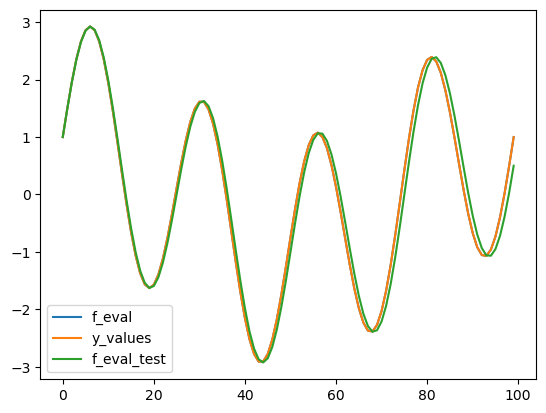

In [19]:
plt.plot(f_eval, label='f_eval')
plt.plot(y_values, label='y_values')
plt.plot(f_eval_test, label='f_eval_test')
plt.legend()

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$



In [20]:
key = random.PRNGKey(0)

n_coef = 5000
coef_f = random.normal(key, shape= (n_coef,))
# We pad the coefficients with a zero
c = 0.0 # constant
coef_f_pad = jnp.hstack([jnp.zeros(1)+ 2*c, coef_f])
coef_f_cos =  jnp.hstack([jnp.zeros(1)+ 2*c,jnp.zeros(n_coef)])

In [21]:
lower = 0.0
upper = 1.0

In [31]:
f_values =  evaluate_real_domain(coef_f_cos,coef_f_pad)*jnp.sqrt(2)

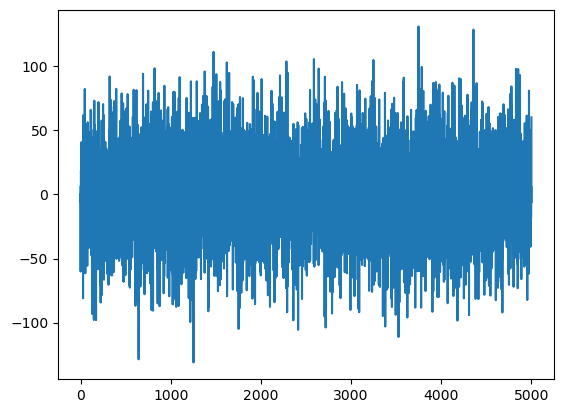

In [32]:
plt.plot(f_values)

In [33]:
# Spectral method 
nu = 0.01
coef_u = coef_f_pad/(nu*jnp.pi*jnp.arange(n_coef+1)**2 + 1)

In [34]:
u_values = evaluate_real_domain(coef_f_cos,coef_u)*jnp.sqrt(2)

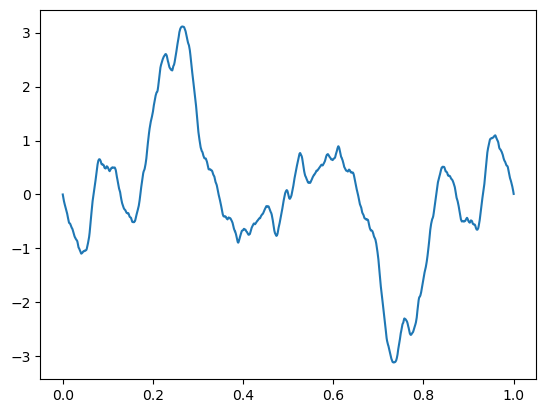

In [35]:
plt.plot(jnp.linspace(0,1,n_coef+1), u_values)
plt.show()

## Kernel method with FFT
We need to compute 

$$
\Theta = \begin{bmatrix}
K(X_{\partial\Omega},X_{\partial\Omega}) & \int L_y K(X_{\partial\Omega}, y)\varphi(y) \\
\int L_y K(X_{\partial\Omega}, y)\varphi(y) ^\intercal & \int \int  L_y L_x K( x, y) \varphi(x)\varphi(y)
\end{bmatrix}
$$

We need to calculate

$$
\int \int \varphi_i(x)\varphi_j(y)L_y L_x K(x,y) dx dy
$$
where the $\varphi$ are the Fourier basis functions. 

We will do so by using the FFT
$$
\int \int \varphi_i(x)\varphi_j(y)L_y L_x K(x,y) dx dy \approx \mathcal{F}_y \mathcal{F}_x L_y L_x K(x,y)
$$

For this we need to evaluate $G(x,y) := \mathcal{F}_y \mathcal{F}_x L_y L_x K(x,y)$ on a grid and apply the FFT seperately to each dimension

In [89]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y

In [360]:
b =lambda x : jnp.ones_like(x)*1.0
length_scale = 1.0
upper = jnp.array([1.0])
lower = jnp.array([0.0])
boundary = jnp.hstack([lower, upper])

In [361]:
domain.shape

(101,)

In [362]:
def get_cos_sin_coef(alpha):
    n = alpha.shape[0]
    c = alpha[0].real/n
    a = 2*alpha.real/n
    b = -2*alpha.imag/n
    return a, b, c

# def get_sin_coef(alpha):
#     n = alpha.shape[0]
#     b = -2*alpha[1:].imag/n
#     return b
# vmap_get_sin_coef = vmap(get_sin_coef, in_axes=(0))

In [429]:
n_meas = 500
domain = jnp.linspace(0,1,n_meas+1) # We add a point because we do not want the constant

#theta_22 = vmap_L_b_xy(domain, domain, length_scale, nu, b(domain), b(domain))
theta_22 = vmap_kernel(domain, domain, length_scale)
theta_22_fft = fft.fftn(theta_22, axes = (1,0))[1:, 1:]
# Extract the sine coefficients
theta_22_sine = -2*theta_22_fft.imag/(n_meas + 1)*jnp.sqrt(2)*jnp.sqrt(2)

In [499]:
jnp.linalg.eigh(F.conjugate()@(F.conjugate()@theta_22).conjugate())[0][0]

Array(2.73760563e-12, dtype=float64)

In [510]:
F.T.conjugate()@((F.T.conjugate()@theta_22).conjugate().T)

Array([[224108.13747217+0.00000000e+00j,  -6836.77009282-4.28715134e+01j,
         -1559.87049387-1.95638109e+01j, ...,
          -682.21240982+1.28352476e+01j,  -1559.87049387+1.95638109e+01j,
         -6836.77009282+4.28715134e+01j],
       [ -6836.77009282+4.28715134e+01j,   9339.18668496-1.81898940e-12j,
          3716.90642578+2.33077025e+01j, ...,
         -2220.46882278+5.57067610e+01j,  -3318.52990222+6.24353243e+01j,
         -6836.5012573 +8.57430268e+01j],
       [ -1559.87049387+1.95638109e+01j,   3716.90642578-2.33077025e+01j,
          1669.22165756-7.10542736e-14j, ...,
         -1033.018023  +3.23990585e+01j,  -1559.62512562+3.91276217e+01j,
         -3318.52990222+6.24353243e+01j],
       ...,
       [  -682.21240982-1.28352476e+01j,  -2220.46882278-5.57067610e+01j,
         -1033.018023  -3.23990585e+01j, ...,
           701.03618761+1.13686838e-13j,   1073.01180459+6.72856325e+00j,
          2394.86494058+3.00362658e+01j],
       [ -1559.87049387-1.95638109e+01j,  -3

In [522]:
fft.fft(fft.fft(theta_22, axis =0).T.conjugate(), axis = 0)

Array([[224108.13747217-4.63273864e-12j,  -6836.77009282+4.28715134e+01j,
         -1559.87049387+1.95638109e+01j, ...,
          -682.21240982-1.28352476e+01j,  -1559.87049387-1.95638109e+01j,
         -6836.77009282-4.28715134e+01j],
       [ -6836.77009282-4.28715134e+01j,   9339.18668496-1.77635684e-15j,
          3716.90642578-2.33077025e+01j, ...,
         -2220.46882278-5.57067610e+01j,  -3318.52990222-6.24353243e+01j,
         -6836.5012573 -8.57430268e+01j],
       [ -1559.87049387-1.95638109e+01j,   3716.90642578+2.33077025e+01j,
          1669.22165756-2.13162821e-14j, ...,
         -1033.018023  -3.23990585e+01j,  -1559.62512562-3.91276217e+01j,
         -3318.52990222-6.24353243e+01j],
       ...,
       [  -682.21240982+1.28352476e+01j,  -2220.46882278+5.57067610e+01j,
         -1033.018023  +3.23990585e+01j, ...,
           701.03618761-5.86197757e-14j,   1073.01180459-6.72856325e+00j,
          2394.86494058-3.00362658e+01j],
       [ -1559.87049387+1.95638109e+01j,  -3

In [523]:
jnp.linalg.eigh(fft.fft(fft.fft(theta_22, axis =0).T.conjugate(), axis = 0))[0][0]

Array(6.76801758e-12, dtype=float64)

In [445]:
F = fft.fftn(jnp.eye(2), axes = (1,0))

In [451]:
fft.fft(jnp.array([0,1]))

Array([ 1.+0.j, -1.+0.j], dtype=complex128)

In [459]:
def fourier_transform_matrix(N):
    # Create a matrix of indices
    j = jnp.arange(N).reshape((N, 1))
    k = jnp.arange(N).reshape((1, N))
    
    # Compute the Fourier transform matrix
    omega = jnp.exp(-2j * jnp.pi / N)
    F = omega ** (j * k)
    
    return F

F = fourier_transform_matrix(n_meas+1)

In [471]:
jnp.linalg.eigh(theta_22)[0][0]

Array(1.2763744e-14, dtype=float64)

In [ ]:
theta_22.astype(jnp.float64)

In [472]:
jnp.linalg.eigh(F.conjugate()@theta_22@F)[0][0]

Array(3.59662217e-12, dtype=float64)

In [469]:
jnp.linalg.eigh(F.conjugate()@theta_22@F.conjugate().T)[0][0]

Array(-23862.4693011, dtype=float64)

In [464]:
fft.fftn(theta_22, axes = (1,0))

Array([[224108.13747217-5.00222086e-12j,  -6836.77009282-4.28715134e+01j,
         -1559.87049387-1.95638109e+01j, ...,
          -682.21240982+1.28352476e+01j,  -1559.87049387+1.95638109e+01j,
         -6836.77009282+4.28715134e+01j],
       [ -6836.77009282-4.28715134e+01j,  -6836.5012573 -8.57430268e+01j,
         -3318.52990222-6.24353243e+01j, ...,
          2394.86494058-3.00362658e+01j,   3716.90642578-2.33077025e+01j,
          9339.18668496-5.96855898e-13j],
       [ -1559.87049387-1.95638109e+01j,  -3318.52990222-6.24353243e+01j,
         -1559.62512562-3.91276217e+01j, ...,
          1073.01180459-6.72856325e+00j,   1669.22165756-4.61852778e-14j,
          3716.90642578+2.33077025e+01j],
       ...,
       [  -682.21240982+1.28352476e+01j,   2394.86494058-3.00362658e+01j,
          1073.01180459-6.72856325e+00j, ...,
          -681.97092552+2.56704952e+01j,  -1033.018023  +3.23990585e+01j,
         -2220.46882278+5.57067610e+01j],
       [ -1559.87049387+1.95638109e+01j,   3

In [432]:
jnp.linalg.eigh(theta_22)[0][0], jnp.linalg.eigh(theta_22_fft.imag/(n_meas+1))[0]

(Array(1.2763744e-14, dtype=float64),
 Array([-3.33070890e+00, -9.64041926e-15, -9.06334268e-15, -8.79086292e-15,
        -8.36746588e-15, -7.98632302e-15, -7.17540344e-15, -6.90030577e-15,
        -6.77000893e-15, -6.38921282e-15, -6.32741961e-15, -6.30820543e-15,
        -6.15894876e-15, -6.13490332e-15, -5.94772831e-15, -5.84908221e-15,
        -5.63873191e-15, -5.58019849e-15, -5.53437548e-15, -5.43750765e-15,
        -5.29631933e-15, -5.27093776e-15, -5.13808756e-15, -5.04480774e-15,
        -5.01272173e-15, -5.00208204e-15, -4.86096793e-15, -4.82764149e-15,
        -4.72965136e-15, -4.72377603e-15, -4.67916051e-15, -4.65951127e-15,
        -4.62450294e-15, -4.61165390e-15, -4.54913980e-15, -4.53860183e-15,
        -4.52293239e-15, -4.41423713e-15, -4.39191809e-15, -4.30370887e-15,
        -4.23574601e-15, -4.12266200e-15, -4.01750755e-15, -4.00348580e-15,
        -3.99413837e-15, -3.95240657e-15, -3.92064071e-15, -3.91328578e-15,
        -3.90937515e-15, -3.80270691e-15, -3.76861

In [365]:
def double_fft(K):
    K = vmap(fft.fft, in_axes=(0))(K)
    K = vmap(fft.fft, in_axes=(-1))(K)
    return K

In [366]:
jnp.allclose(theta_22_fft, double_fft(theta_22)[1:, 1:])

Array(True, dtype=bool)

In [423]:
temp = []
for i in range(n_meas+1):
    temp.append(fft.fft(theta_22[i]))
temp = jnp.array(temp)
temp_2 = []
for j in range(n_meas+1):
    temp_2.append(fft.fft(temp[:,j]))
temp_2 = jnp.array(temp_2)

In [424]:
jnp.allclose(theta_22_fft,temp_2[1:, 1:])

Array(True, dtype=bool)

In [425]:
jnp.linalg.eigh(temp_2/(n_meas+1))[0][0]

Array(-9.52554521, dtype=float64)

In [370]:
temp.shape

(101, 101)

In [371]:
jnp.linalg.eigh(theta_22_sine)[0][0]

Array(-6.49804687, dtype=float64)

In [229]:
eigenvalues, _ = jnp.linalg.eigh(theta_22_sine)

In [230]:
eigenvalues[0]

Array(-0.05234888, dtype=float64)

In [152]:
# Upper blocks of K (boundary)
theta_11 = vmap_kernel(boundary,boundary, length_scale)

In [180]:
eigenvalues, _ = jnp.linalg.eigh(theta_11)

In [153]:
# Cross terms (boundary and domain)
theta_12 = vmap_L_b_y(boundary,  domain, length_scale, nu, b(domain))
theta_12= fft.fftn(theta_12, axes = (1,))
# Eliminate the constant term
theta_12 = theta_12[:, 1:]
# Extract the sine coefficients
theta_12_sine = -2*theta_12.imag/(n_meas+1)

In [154]:
K = jnp.block([[theta_11, theta_12_sine],[theta_12_sine.T, theta_22_sine]])

In [155]:
eigenvalues, _ = jnp.linalg.eigh(K)

In [156]:
eigenvalues[0]

Array(-7.28098765, dtype=float64)

# A 2D example

In [525]:
j,k= 1,5
m,n = 2,4
f = lambda x,y: jnp.cos(2*jnp.pi*(j*x + k*y)) + 4.12*jnp.sin(2*jnp.pi*(m*x + n*y))

In [526]:
domain = jnp.array([0,1])

# 2d grid 
x = jnp.linspace(domain[0], domain[1], n_points)
y = jnp.linspace(domain[0], domain[1], n_points)
X, Y = jnp.meshgrid(x, y)

In [527]:
values = f(X,Y)

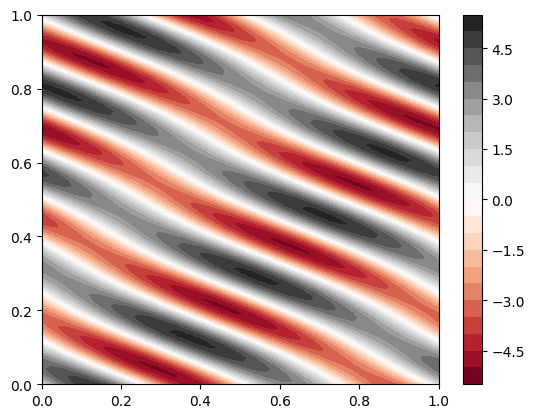

In [528]:
# 2D plot
plt.contourf(X, Y, values, 20, cmap='RdGy')
plt.colorbar()

In [529]:
alpha = fft.fft2(values)

In [530]:
def get_cos_sin_coef_2d(alpha):
    n = alpha.shape[0]
    m = alpha.shape[1]
    c = alpha[0,0].real/(n*m)
    a = 2*alpha.real/(n*m)
    b = -2*alpha.imag/(n*m)
    return a, b, c


In [531]:
a, b, c = get_cos_sin_coef_2d(alpha)

In [532]:
def evaluate_real_domain(a,b):
    m,n = a.shape
    return fft.ifftn((a - 1j*b)*(m*n)/2).real

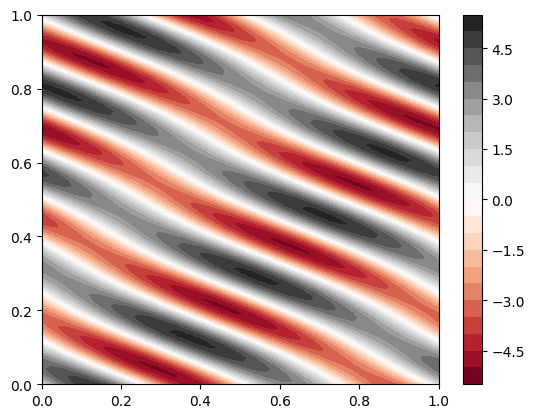

In [533]:
f_eval = evaluate_real_domain(a,b)
# 2D plot
plt.contourf(X, Y, f_eval, 20, cmap='RdGy')
# colorbar
plt.colorbar()

In [534]:
jnp.mean(jnp.abs(f_eval - values))

Array(6.91410817e-16, dtype=float64)

In [535]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [559]:
a_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)
b_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)  

a_test = a_test.at[k,j].set(1)
b_test = b_test.at[n,m].set(2)*4.12

In [564]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [560]:
f_eval_test = evaluate_real_domain(a_test,b_test)
jnp.mean(jnp.abs(f_eval_test - values))

Array(0.56350486, dtype=float64)

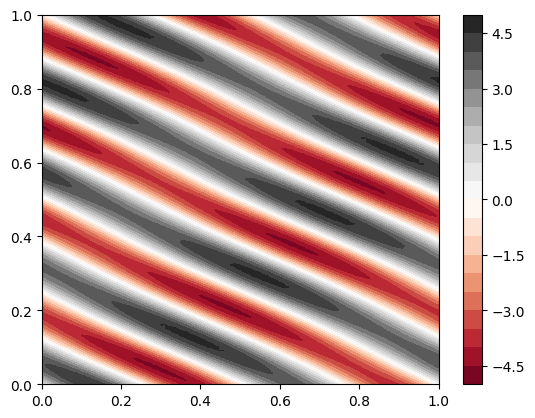

In [561]:
plt.contourf(X, Y, f_eval_test, 20, cmap='RdGy')
# colorbar
plt.colorbar()

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

